In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.transforms as transforms
from rewards import *
from utils import *
from strategies import *
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
# plot tools
color_map = {0 : 'red',
             1 : 'green'}

# Linear reward

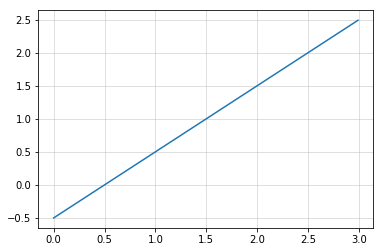

In [3]:
t = np.arange(0,3,0.01)
rew = affineReward(dirCoef=1, originOrd=-0.5)
#rew = customReward(number=4)
plt.plot(t, rew.eval(t))
plt.grid(alpha=0.5)

## Default parameters

In [4]:
## Samples distribution
maxride = 3
ridedistribution = uniformRide(maxval=maxride)

## Reward function
rew = affineReward(dirCoef=1, originOrd=-0.5)

## Poisson rate
rate = 1

In [5]:
samples = ridedistribution.simu(1000000)
rewards = rew.eval(samples)
cstar = profOpt(rewards, samples, rate=rate, precision=1e-8)
print('c* = {}'.format(cstar))

c* = 0.4291945919394493


In [6]:
phi = phi_function_vector(rewards, samples, rate=rate)

No handles with labels found to put in legend.


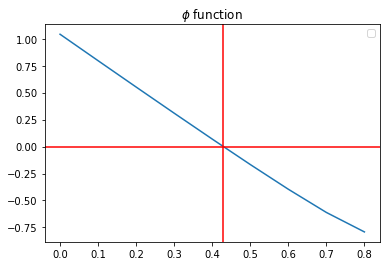

In [7]:
t = np.arange(0,2*cstar,0.1)
plt.plot(t,phi(t),label = '')
plt.axvline(x=cstar,color='r')
plt.axhline(y=0,color='r')
plt.title(r'$\phi$ function')
plt.legend()

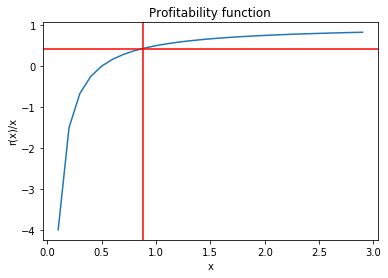

In [8]:
plt.title('Profitability function')
t = np.arange(0,maxride,0.1)
plt.plot(t, rew.eval(t)/t)
plt.axhline(y=cstar, color='r')
for x in rew.thresholds(cstar, maxride=maxride):
    plt.axvline(x=x, color='r')
plt.ylabel('r(x)/x')
plt.xlabel('x')
plt.show()

## Case of known reward

In [9]:
expe = 1
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
horizon = 100000

t = time.time()
algo = UnknownDistribution_RBT(rew, maxrew=maxrew, delta=1/horizon, minrew=minrew)
total_reward, proposed_rides, accepts, proposal_times, cstars = simu(rew, ridedistribution, algo,
                                                             rate=1, horizon=horizon, track_history=True)
print("Total time = {} s".format(time.time()-t))

Total time = 10.303554773330688 s


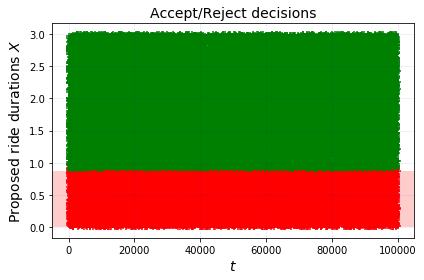

In [10]:
c = [color_map[b[0]] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), backend='pgf', transparent=True, dpi=300)
plt.show()

Accepted rides in green and refused rides in red where the area in red represents suboptimal rides. 

## Bandit setting

In [11]:
horizon = 100000
beta, L = rew.holder(maxride=maxride)
print("(beta, L) = ({}, {})".format(beta, L))
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
noise = uniformNoise(1)
# we have to set kappa small, because for the value kappa=150, it is too significant for reasonable horizons
algo = Bandit_RBT(horizon=horizon, L=L, beta=beta, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var, kappa=0.5)
t = time.time()
total_reward, proposed_rides, accepts, proposal_times, _ = simu(rew, ridedistribution, algo, noise=noise, 
                                                             rate=1, horizon=horizon, track_history=True)
print("Time for simulation = {} s".format(time.time()-t))

(beta, L) = (1, 1)
Time for simulation = 7.62394380569458 s


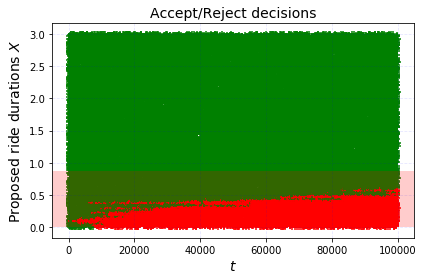

In [12]:
c = [color_map[b] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), backend='pgf', transparent=True, dpi=300)
plt.show()

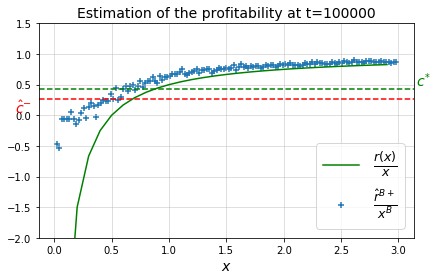

In [13]:
fig, ax=plt.subplots()
plt.grid(alpha=0.5)
ax.scatter(algo.X, (algo.sum_rewards/algo.N+algo.eta)/algo.X, marker='+', label=r'$\frac{\hat{r}^{B +}}{x^B}$')
t = np.arange(0,maxride,0.1)
ax.plot(t, rew.eval(t)/t, label=r'$\frac{r(x)}{x}$', color='green')
ax.axhline(y=cstar, color='green', linestyle='--') # plot true cstar
ax.axhline(y=max(algo.c-algo.xi,0), color='red', linestyle='--') # estimated cstar
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,max(algo.c-algo.xi,0), r'$\hat{c}^{-}$', color="red", transform=trans, 
        ha="right", va="top", fontsize=14)
ax.text(1.025, cstar, r'$c^{*}$', color="green", transform=trans, 
        ha="left", va="bottom", fontsize=14)
plt.xlabel(r'$x$', fontsize=14)
ax.legend(fontsize=18)
plt.ylim(-2,1.5)
plt.title('Estimation of the profitability at t={}'.format(algo.horizon), fontsize=14)
plt.tight_layout()
plt.savefig('figures/estimation_{}_{}_{}_{}.pdf'.format(rew.name, algo.name.replace(' ', ''), expe, algo.horizon), backend='pgf', transparent=True)
plt.show()

## Monotone algorithm

In [14]:
horizon = 100000
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
noise = uniformNoise(1)
algo = Monotone(horizon=horizon, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var)
algo.sigma /= 60 # we "cheat" here as for the kappa in the bandit algorithm
t = time.time()
total_reward, proposed_rides, accepts, proposal_times, _ = simu(rew, ridedistribution, algo, noise=noise, 
                                                             rate=1, horizon=horizon, track_history=True)
print("Time for simulation = {} s".format(time.time()-t))

Time for simulation = 32.29751253128052 s


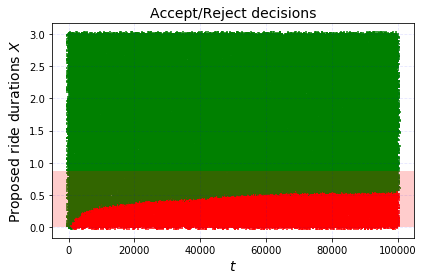

In [15]:
c = [color_map[b] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
plt.title('Decision on a single simulation.')
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), dpi=300, backend='pgf', transparent=True)
plt.show()

# Concave reward

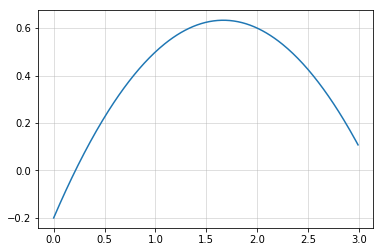

In [16]:
t = np.arange(0,3,0.01)
#rew = affineReward(dirCoef=1, originOrd=-0.5)
rew = concaveReward2(a=1, b=0.2, c=0.3)
expe = 2
plt.plot(t, rew.eval(t))
plt.grid(alpha=0.5)

## Default parameters

In [17]:
## Samples distribution
maxride = 3
ridedistribution = uniformRide(maxval=maxride)

## Reward function

## Poisson rate
rate = 1

In [18]:
samples = ridedistribution.simu(1000000)
rewards = rew.eval(samples)
cstar = profOpt(rewards, samples, rate=rate, precision=1e-8)
print('c* = {}'.format(cstar))

c* = 0.17777854949235916


In [19]:
phi = phi_function_vector(rewards, samples, rate=rate)

No handles with labels found to put in legend.


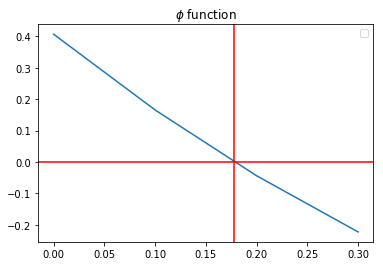

In [20]:
t = np.arange(0,2*cstar,0.1)
plt.plot(t,phi(t),label = '')
plt.axvline(x=cstar,color='r')
plt.axhline(y=0,color='r')
plt.title(r'$\phi$ function')
plt.legend()

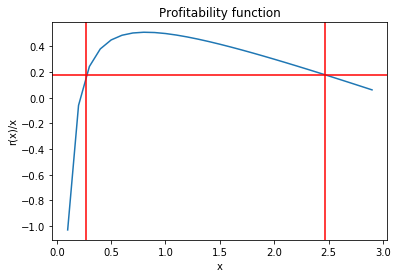

In [21]:
plt.title('Profitability function')
t = np.arange(0,maxride,0.1)
plt.plot(t, rew.eval(t)/t)
plt.axhline(y=cstar, color='r')
for x in rew.thresholds(cstar, maxride=maxride):
    plt.axvline(x=x, color='r')
plt.ylabel('r(x)/x')
plt.xlabel('x')
plt.show()

## Case of known reward

In [22]:
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
horizon = 100000

t = time.time()
algo = UnknownDistribution_RBT(rew, maxrew=maxrew, delta=1/horizon, minrew=minrew)
total_reward, proposed_rides, accepts, proposal_times, cstars = simu(rew, ridedistribution, algo,
                                                             rate=1, horizon=horizon, track_history=True)
print("Total time = {} s".format(time.time()-t))

Total time = 11.78013801574707 s


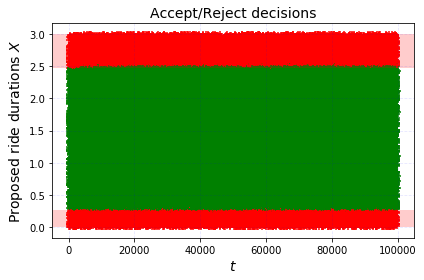

In [23]:
c = [color_map[b[0]] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), backend='pgf', transparent=True, dpi=300)
plt.show()

In [24]:
print(algo.n)
print(algo.tree.count())
print(algo.tree.height())
print(algo.tree.is_red_black())
print(algo.c)

49028
1196
13
[ True]
[0.16777968]


Accepted rides in green and refused rides in red where the area in red represents suboptimal rides. 

## Bandit setting

In [25]:
horizon = 100000
beta, L = rew.holder(maxride=maxride)
print("(beta, L) = ({}, {})".format(beta, L))
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
noise = gaussianNoise(0.1)
# we have to set kappa small, because for the value kappa=150, it is too significant for reasonable horizons
algo = Bandit_RBT(horizon=horizon, L=L, beta=beta, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var, kappa=0.5)
t = time.time()
total_reward, proposed_rides, accepts, proposal_times, _ = simu(rew, ridedistribution, algo, noise=noise, 
                                                             rate=1, horizon=horizon, track_history=True)
print("Time for simulation = {} s".format(time.time()-t))

(beta, L) = (1, 1)
Time for simulation = 8.925706624984741 s


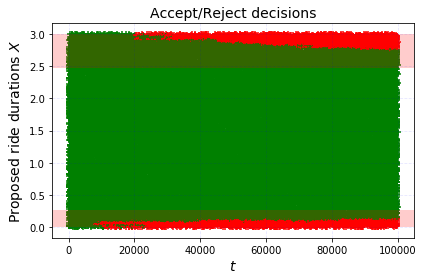

In [26]:
c = [color_map[b] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), dpi=300, backend='pgf', transparent=True)
plt.show()

In [27]:
print(algo.c)
print(algo.tree.count())
print(algo.nbuckets)
print(algo.tree.height())
print(algo.tree.is_red_black())

0.17900009777743442
140
140
10
True


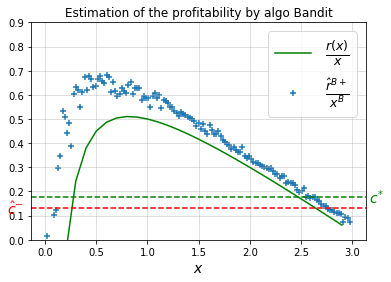

In [28]:
fig, ax=plt.subplots()
plt.grid(alpha=0.5)
ax.scatter(algo.X, (algo.sum_rewards/algo.N+algo.eta)/algo.X, marker='+', label=r'$\frac{\hat{r}^{B +}}{x^B}$')
t = np.arange(0,maxride,0.1)
ax.plot(t, rew.eval(t)/t, label=r'$\frac{r(x)}{x}$', color='green')
ax.axhline(y=cstar, color='green', linestyle='--') # plot true cstar
ax.axhline(y=max(algo.c-algo.xi,0), color='red', linestyle='--') # estimated cstar
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,max(algo.c-algo.xi,0), r'$\hat{c}^{-}$', color="red", transform=trans, 
        ha="right", va="center", fontsize=14)
ax.text(1.075,cstar, r'$c^{*}$', color="green", transform=trans, 
        ha="right", va="center", fontsize=14)
plt.xlabel(r'$x$', fontsize=14)
ax.legend(fontsize=18)
plt.ylim(0, 0.9)
plt.title('Estimation of the profitability by algo {}'.format(algo.name))
plt.savefig('figures/estimation_{}_{}_{}_{}.pdf'.format(rew.name, algo.name.replace(' ', ''), expe, algo.horizon), backend='pgf', transparent=True)
plt.show()

# Concave reward and discrete ride distribution

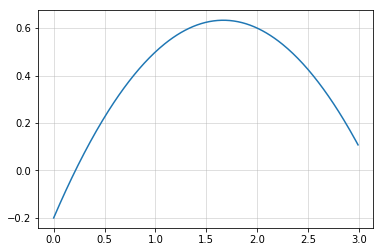

In [29]:
t = np.arange(0,3,0.01)
#rew = affineReward(dirCoef=1, originOrd=-0.5)
expe = 3
rew = concaveReward2(a=1, b=0.2, c=0.3)
plt.plot(t, rew.eval(t))
plt.grid(alpha=0.5)

## Default parameters

In [30]:
## Samples distribution
maxride = 3
K = 20
ridedistribution = uniformRide(maxval=maxride, discrete=True, K=K)

## Reward function

## Poisson rate
rate = 1

In [31]:
samples = ridedistribution.simu(1000000)
rewards = rew.eval(samples)
cstar = profOpt(rewards, samples, rate=rate, precision=1e-8)
print('c* = {}'.format(cstar))

c* = 0.17341231554746628


In [32]:
phi = phi_function_vector(rewards, samples, rate=rate)

No handles with labels found to put in legend.


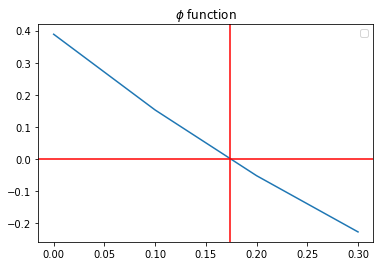

In [33]:
t = np.arange(0,2*cstar,0.1)
plt.plot(t,phi(t),label = '')
plt.axvline(x=cstar,color='r')
plt.axhline(y=0,color='r')
plt.title(r'$\phi$ function')
plt.legend()

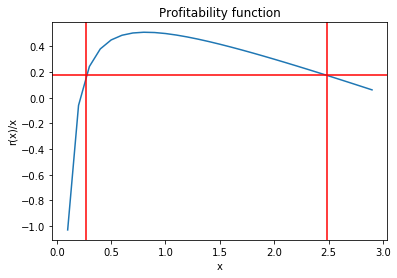

In [34]:
plt.title('Profitability function')
t = np.arange(0,maxride,0.1)
plt.plot(t, rew.eval(t)/t)
plt.axhline(y=cstar, color='r')
for x in rew.thresholds(cstar, maxride=maxride):
    plt.axvline(x=x, color='r')
plt.ylabel('r(x)/x')
plt.xlabel('x')
plt.show()

## Case of known reward

In [35]:
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
horizon = 10000

t = time.time()
algo = UnknownDistribution_RBT(rew, maxrew=maxrew, delta=1/horizon, minrew=minrew)
total_reward, proposed_rides, accepts, proposal_times, cstars = simu(rew, ridedistribution, algo,
                                                             rate=1, horizon=horizon, track_history=True)
print("Total time = {} s".format(time.time()-t))

Total time = 1.2985754013061523 s


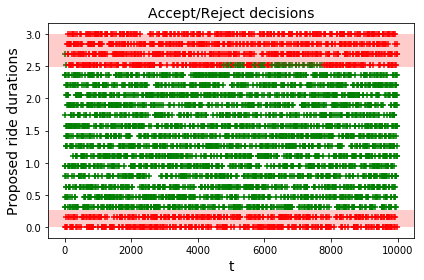

In [36]:
c = [color_map[b[0]] for b in accepts]
plt.title('Accept/Reject decisions', fontsize=14)
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.xlabel('t', fontsize=14)
plt.ylabel('Proposed ride durations', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), dpi=300, backend='pgf', transparent=True)
plt.show()

Accepted rides in green and refused rides in red where the area in red represents suboptimal rides. 

## Bandit setting

In [37]:
horizon = 100000
beta, L = rew.holder(maxride=maxride)
print("(beta, L) = ({}, {})".format(beta, L))
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
noise = gaussianNoise(0.1)
# we have to set kappa small, because for the value kappa=150, it is too significant for reasonable horizons
algo = Bandit_RBT(horizon=horizon, L=L, beta=beta, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var, kappa=0.5)
t = time.time()
total_reward, proposed_rides, accepts, proposal_times, _ = simu(rew, ridedistribution, algo, noise=noise, 
                                                             rate=1, horizon=horizon, track_history=True)
print("Time for simulation = {} s".format(time.time()-t))

(beta, L) = (1, 1)
Time for simulation = 8.750771760940552 s


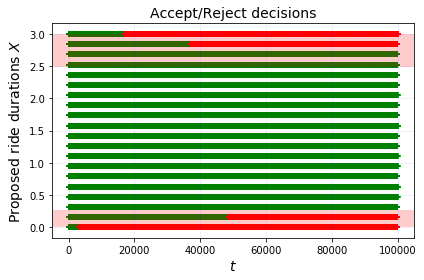

In [38]:
c = [color_map[b] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), dpi=300, backend='pgf', transparent=True)
plt.show()

In [39]:
print(algo.c)
print(algo.tree.count())
print(algo.nbuckets)
print(algo.tree.height())
print(algo.tree.is_red_black())

0.17302355470005645
20
140
6
True


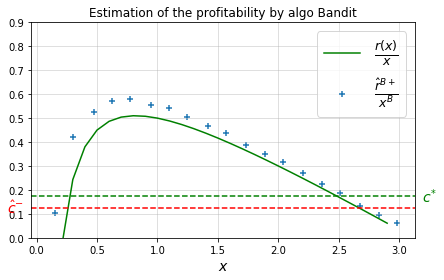

In [40]:
fig, ax=plt.subplots()
plt.grid(alpha=0.5)
ax.scatter(algo.X, (algo.sum_rewards/algo.N+algo.eta)/algo.X, marker='+', label=r'$\frac{\hat{r}^{B +}}{x^B}$')
t = np.arange(0,maxride,0.1)
ax.plot(t, rew.eval(t)/t, label=r'$\frac{r(x)}{x}$', color='green')
ax.axhline(y=cstar, color='green', linestyle='--') # plot true cstar
ax.axhline(y=max(algo.c-algo.xi,0), color='red', linestyle='--') # estimated cstar
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,max(algo.c-algo.xi,0), r'$\hat{c}^{-}$', color="red", transform=trans, 
        ha="right", va="center", fontsize=14)
ax.text(1.075,cstar, r'$c^{*}$', color="green", transform=trans, 
        ha="right", va="center", fontsize=14)
plt.xlabel(r'$x$', fontsize=14)
ax.legend(fontsize=18)
plt.ylim(0, 0.9)
plt.title('Estimation of the profitability by algo {}'.format(algo.name))
plt.tight_layout()
plt.savefig('figures/estimation_{}_{}_{}_{}.pdf'.format(rew.name, algo.name.replace(' ', ''), expe, algo.horizon), backend='pgf', transparent=True)
plt.show()

# Finite bandit algo

In [41]:
horizon = 100000
beta, L = rew.holder(maxride=maxride)
print("(beta, L) = ({}, {})".format(beta, L))
t = np.arange(0, maxride, 1e-3)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))
noise = gaussianNoise(0.1)
algo = FiniteBandit_RBT(horizon=horizon, X=ridedistribution.support, rate=1, maxrew=maxrew, minrew=minrew, var=noise.var)
t = time.time()
total_reward, proposed_rides, accepts, proposal_times, _ = simu(rew, ridedistribution, algo, noise=noise, 
                                                             rate=1, horizon=horizon, track_history=True)
print("Time for simulation = {} s".format(time.time()-t))

(beta, L) = (1, 1)
Time for simulation = 8.05341100692749 s


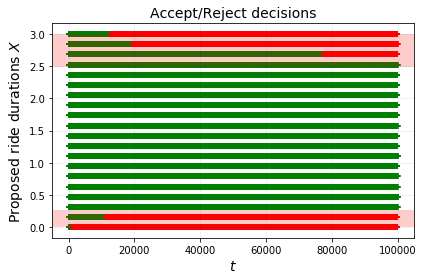

In [42]:
c = [color_map[b] for b in accepts]
plt.grid(alpha=0.1, color='blue', linestyle='--')
plt.scatter(x=proposal_times, y=proposed_rides, marker='+', c=c)
x,l = rew.opt_areas(cstar=cstar, maxride=maxride)
for i in range(len(l)):
    if not(l[i]): # sub-optimal area
        plt.axhspan(x[i], x[i+1], facecolor='red', alpha=0.2)
plt.title('Accept/Reject decisions', fontsize=14)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'Proposed ride durations $X$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/decisions_{}_{}_{}.png'.format(rew.name, algo.name.replace(' ', ''), expe), dpi=300, backend='pgf', transparent=True)
plt.show()

In [43]:
print(algo.c)
print(algo.tree.count())
print(algo.tree.height())
print(algo.tree.is_red_black())

0.1733271086611288
20
6
True


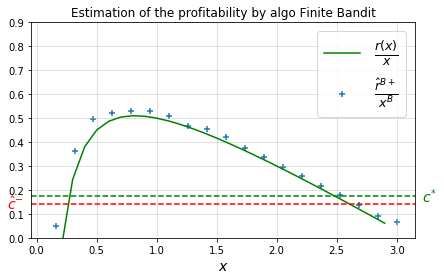

In [44]:
fig, ax=plt.subplots()
plt.grid(alpha=0.5)
ax.scatter(algo.X, (algo.sum_rewards/algo.N+algo.eta)/algo.X, marker='+', label=r'$\frac{\hat{r}^{B +}}{x^B}$')
t = np.arange(0,maxride,0.1)
ax.plot(t, rew.eval(t)/t, label=r'$\frac{r(x)}{x}$', color='green')
ax.axhline(y=cstar, color='green', linestyle='--') # plot true cstar
ax.axhline(y=max(algo.c-algo.xi,0), color='red', linestyle='--') # estimated cstar
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,max(algo.c-algo.xi,0), r'$\hat{c}^{-}$', color="red", transform=trans, 
        ha="right", va="center", fontsize=14)
ax.text(1.075,cstar, r'$c^{*}$', color="green", transform=trans, 
        ha="right", va="center", fontsize=14)
plt.xlabel(r'$x$', fontsize=14)
ax.legend(fontsize=18)
plt.ylim(0, 0.9)
plt.title('Estimation of the profitability by algo {}'.format(algo.name))
plt.tight_layout()
plt.savefig('figures/estimation_{}_{}_{}_{}.pdf'.format(rew.name, algo.name.replace(' ', ''), expe, algo.horizon), backend='pgf', transparent=True)
plt.show()